In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
from sklearn.preprocessing import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
warnings.filterwarnings('ignore')

In [25]:
# Configuración de visualización
sns.set_theme(style="darkgrid", palette="husl")
sns.set_palette("husl")

In [26]:
# Cargar el archivo 
try:
    df = pd.read_csv("./data/train.csv", encoding='utf-8')
    print("Archivo cargado correctamente.")
except FileNotFoundError:
    print("No se encontró el archivo. Verifica la ruta.")
    raise

Archivo cargado correctamente.


In [27]:
df.drop_duplicates()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,...,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,25096,20195,BIOLOGIA,LA GUAJIRA,Entre 500 mil y menos de 1 millón,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,...,N,Si,Si,Si,Secundaria (Bachillerato) incompleta,medio-alto,0.237,0.271,0.271,0.311
692496,754213,20212,PSICOLOGIA,NORTE SANTANDER,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Primaria incompleta,Si,...,N,No,Si,Si,Secundaria (Bachillerato) incompleta,bajo,0.314,0.240,0.278,0.260
692497,504185,20183,ADMINISTRACIÓN EN SALUD OCUPACIONAL,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Menos de 10 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,Si,Si,Si,Secundaria (Bachillerato) incompleta,medio-bajo,0.286,0.240,0.314,0.287
692498,986620,20195,PSICOLOGIA,TOLIMA,Entre 2.5 millones y menos de 4 millones,Menos de 10 horas,Estrato 1,No,Primaria completa,No,...,N,Si,Si,No,Primaria completa,bajo,0.132,0.426,0.261,0.328


In [28]:
# Exploración inicial
print("Forma del DataFrame:", df.shape)
print("\nColumnas:", df.columns.tolist())
df.info()
display(df.describe())

Forma del DataFrame: (692500, 21)

Columnas: ['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'coef_1', 'coef_2', 'coef_3', 'coef_4']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              692500 non-null  int64  
 1   PERIODO                         692500 non-null  int64  
 2   ESTU_PRGM_ACADEMICO             692500 non-null  object 
 3   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   ESTU_VALORMATRICULAUNIVERSIDAD  686213 

,ID,PERIODO,coef_1,coef_2,coef_3,coef_4
count,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000
mean,494606.130576,20198.366679,0.268629,0.259996,0.262087,0.262903
std,285585.209455,10.535037,0.122130,0.093480,0.058862,0.067944
min,1.000000,20183.000000,0.000000,0.000000,0.000000,0.000000
25%,247324.750000,20195.000000,0.203000,0.212000,0.254000,0.255000
50%,494564.500000,20195.000000,0.240000,0.271000,0.276000,0.285000
75%,741782.500000,20203.000000,0.314000,0.309000,0.293000,0.303000
max,989286.000000,20213.000000,0.657000,0.487000,0.320000,0.332000


In [29]:
#cambiar nombre de las columnas por caracteres en minisculas para mejor uso
df.columns= df.columns.str.strip().str.lower()

In [30]:
# Estadisticas descriptiva y estrutura
print("Primeras filas del dataset:")
print(df.head())
print("\nResumen estadístico de variables numéricas:")
print(df.describe())
print("\nResumen de variables categóricas:")
print(df.select_dtypes(include='object').describe())


Primeras filas del dataset:
       id  periodo         estu_prgm_academico estu_prgm_departamento  \
0  904256    20212                  ENFERMERIA                 BOGOTÁ   
1  645256    20212                     DERECHO              ATLANTICO   
2  308367    20203       MERCADEO Y PUBLICIDAD                 BOGOTÁ   
3  470353    20195  ADMINISTRACION DE EMPRESAS              SANTANDER   
4  989032    20212                  PSICOLOGIA              ANTIOQUIA   

             estu_valormatriculauniversidad estu_horassemanatrabaja  \
0  Entre 5.5 millones y menos de 7 millones       Menos de 10 horas   
1  Entre 2.5 millones y menos de 4 millones                       0   
2  Entre 2.5 millones y menos de 4 millones         Más de 30 horas   
3  Entre 4 millones y menos de 5.5 millones                       0   
4  Entre 2.5 millones y menos de 4 millones     Entre 21 y 30 horas   

  fami_estratovivienda fami_tieneinternet                 fami_educacionpadre  \
0            Estrato 3   

In [31]:
# Revisión de valores nulos
print("Valores nulos por columna:")
print(df.isna().sum().sort_values(ascending=False))

Valores nulos por columna:
fami_tieneautomovil               43623
fami_tienelavadora                39773
fami_tienecomputador              38103
fami_estratovivienda              32137
estu_horassemanatrabaja           30857
fami_tieneinternet                26629
fami_tieneinternet.1              26629
fami_educacionmadre               23664
fami_educacionpadre               23178
estu_pagomatriculapropio           6498
estu_valormatriculauniversidad     6287
coef_3                                0
coef_2                                0
coef_1                                0
rendimiento_global                    0
id                                    0
estu_privado_libertad                 0
periodo                               0
estu_prgm_departamento                0
estu_prgm_academico                   0
coef_4                                0
dtype: int64



Porcentaje de valores nulos por columna:
fami_tieneautomovil               6.299350
fami_tienelavadora                5.743394
fami_tienecomputador              5.502238
fami_estratovivienda              4.640722
estu_horassemanatrabaja           4.455884
fami_tieneinternet                3.845343
fami_tieneinternet.1              3.845343
fami_educacionmadre               3.417184
fami_educacionpadre               3.347004
estu_pagomatriculapropio          0.938339
estu_valormatriculauniversidad    0.907870
coef_3                            0.000000
coef_2                            0.000000
coef_1                            0.000000
rendimiento_global                0.000000
id                                0.000000
estu_privado_libertad             0.000000
periodo                           0.000000
estu_prgm_departamento            0.000000
estu_prgm_academico               0.000000
coef_4                            0.000000
dtype: float64


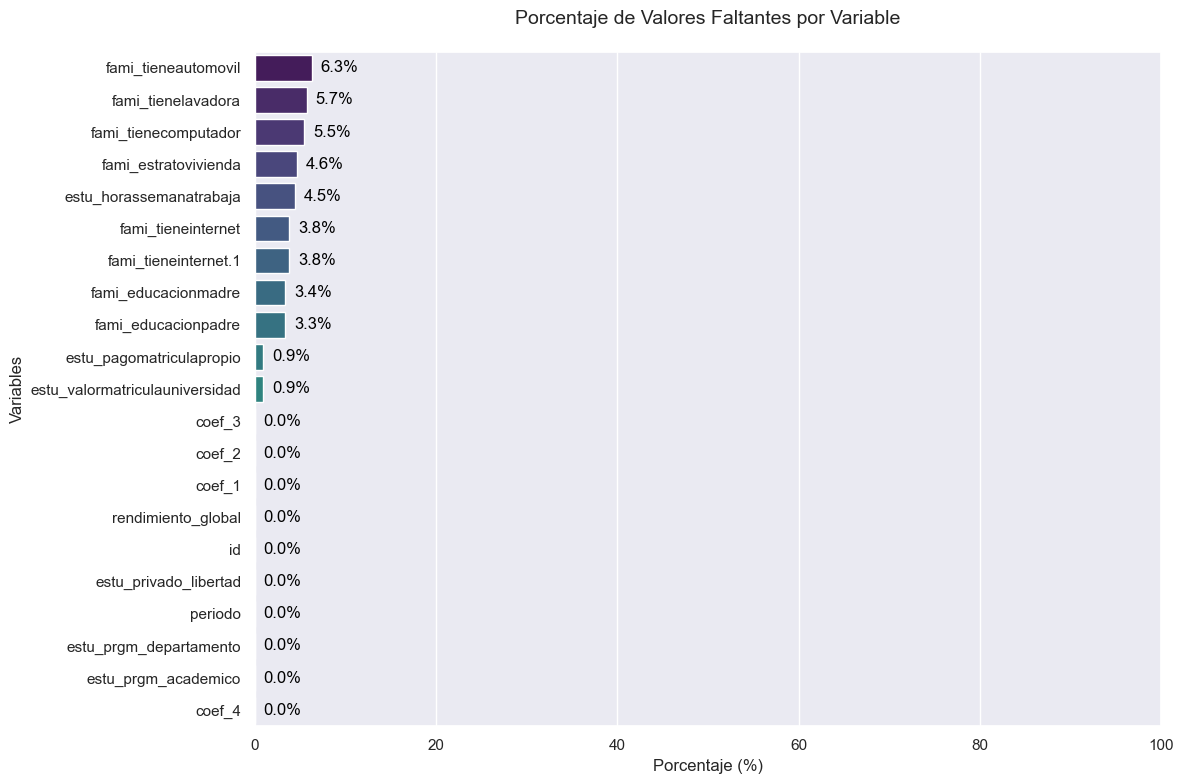

In [32]:
# Análisis de valores nulos
print("\nPorcentaje de valores nulos por columna:")
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print(missing_pct)  # Mostrar los porcentajes en la consola

# Visualización
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=missing_pct.values, y=missing_pct.index, palette="viridis")

# Mejoras en la visualización
plt.title('Porcentaje de Valores Faltantes por Variable', fontsize=14, pad=20)
plt.xlabel('Porcentaje (%)', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.xlim(0, 100)  # Establecer límite máximo del 100%

# Agregar etiquetas de valor
for i, v in enumerate(missing_pct.values):
    ax.text(v + 1, i, f"{v:.1f}%", color='black', va='center')

plt.tight_layout()  # Ajustar layout para evitar cortes
plt.show()

In [33]:
# Eliminar columnas con más del 50% de valores nulos
threshold = 0.5
missing = df.isna().mean()
cols_to_drop = missing[missing > threshold].index
print(f"Columnas eliminadas por exceso de nulos: {cols_to_drop.tolist()}")
df.drop(columns=cols_to_drop, inplace=True)

Columnas eliminadas por exceso de nulos: []


In [34]:
# Transformación de variables numéricas
rangos_valores = {
    'estu_valormatriculauniversidad_menos de 500 mil': 0.25,
    'estu_valormatriculauniversidad_entre 500 mil y menos de 1 millón': 0.75,
    'estu_valormatriculauniversidad_entre 1 millón y menos de 2.5 millones': 1.75,
    'estu_valormatriculauniversidad_entre 2.5 millones y menos de 4 millones': 3.25,
    'estu_valormatriculauniversidad_entre 4 millones y menos de 5.5 millones': 4.75,
    'estu_valormatriculauniversidad_entre 5.5 millones y menos de 7 millones': 6.25,
    'estu_valormatriculauniversidad_más de 7 millones': 8.00,
    'estu_valormatriculauniversidad_no pagó matrícula': 0.00
}

df['valormatricula_numerico'] = sum(
    df[col] * val for col, val in rangos_valores.items() if col in df.columns
)


In [35]:
# Estrategias de imputación
class AdvancedImputer:
    def __init__(self):
        self.num_imputer = IterativeImputer(random_state=42)
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
        
    def fit_transform(self, df):
        # Numéricas
        num_cols = df.select_dtypes(include=np.number).columns
        df[num_cols] = self.num_imputer.fit_transform(df[num_cols])
        
        # Categóricas
        cat_cols = df.select_dtypes(include=['object']).columns
        df[cat_cols] = self.cat_imputer.fit_transform(df[cat_cols])
        
        return df

imputer = AdvancedImputer()
df = imputer.fit_transform(df)

In [36]:

def codificacion_avanzada(df, target_col=None, umbral=10):
    """
    Aplica codificación avanzada a variables categóricas:
    - Target Encoding para características con alta cardinalidad
    - One-Hot Encoding para características con baja cardinalidad

    Parámetros:
    df: DataFrame a codificar
    target_col: nombre de la columna objetivo para usar en Target Encoding
    umbral: Límite de cardinalidad para decidir entre target y one-hot encoding (por defecto=10)

    Retorna:
    DataFrame con variables categóricas codificadas.
    """
    if target_col is None or target_col not in df.columns:
        raise ValueError("Debes especificar una columna 'target_col' válida para aplicar Target Encoding.")

    # 1. Identificar columnas categóricas
    columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns

    # 2. Separar características por cardinalidad
    columnas_alta_card = [col for col in columnas_categoricas if df[col].nunique() > umbral]
    columnas_baja_card = [col for col in columnas_categoricas if col not in columnas_alta_card]

    # 3. One-Hot Encoding para baja cardinalidad
    if columnas_baja_card:
        codificador_oh = OneHotEncoder(drop='first', sparse_output=False)
        matriz_oh = codificador_oh.fit_transform(df[columnas_baja_card])
        columnas_oh = codificador_oh.get_feature_names_out(columnas_baja_card)
        df_oh = pd.DataFrame(matriz_oh, columns=columnas_oh, index=df.index)
    else:
        df_oh = pd.DataFrame(index=df.index)

    # 4. Target Encoding para alta cardinalidad
    if columnas_alta_card:
        codificador_target = TargetEncoder(cols=columnas_alta_card)
        df_target = codificador_target.fit_transform(df[columnas_alta_card], df[target_col])
    else:
        df_target = pd.DataFrame(index=df.index)

    # 5. Eliminar columnas categóricas originales y unir todo
    df_sin_cat = df.drop(columns=columnas_categoricas)
    df_codificado = pd.concat([df_sin_cat, df_oh, df_target], axis=1)

    return df_codificado


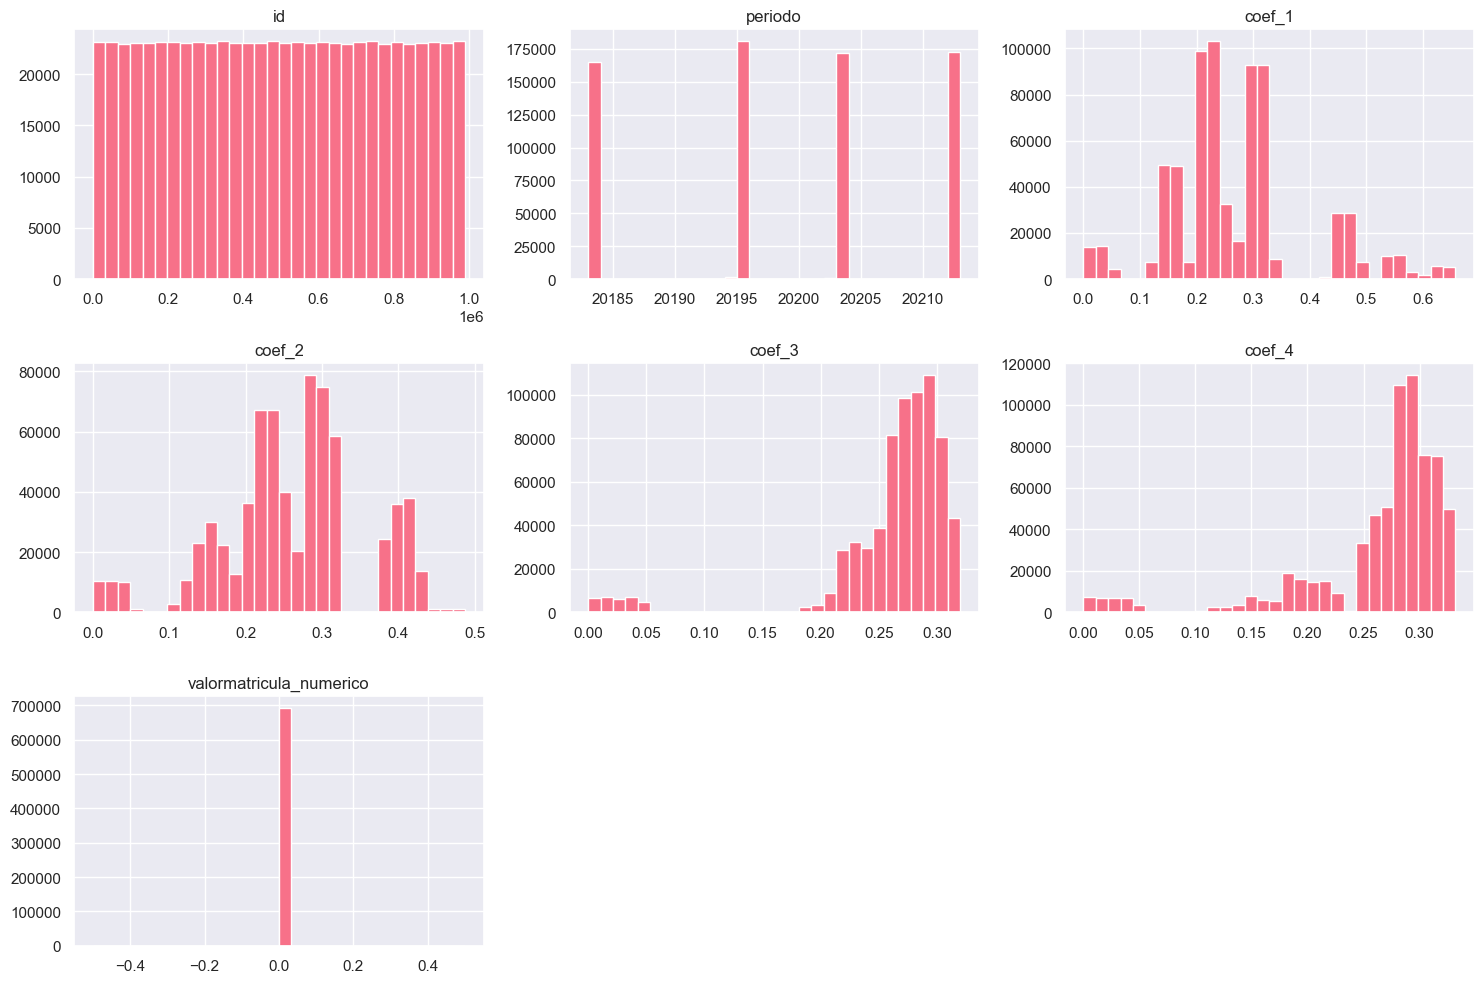

In [37]:
# Histograma de variables numéricas
df.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()


In [38]:
# Normalización avanzada
scaler = StandardScaler()
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = scaler.fit_transform(df[num_cols])


In [42]:
# 1. Crear variable target binaria
df['rendimiento_global_medio-alto'] = (df['rendimiento_global'] == 'medio-alto').astype(int)

# 2. Aplicar codificación avanzada antes de definir features
df = codificacion_avanzada(df, target_col='rendimiento_global_medio-alto')

# 3. Eliminar duplicados de columnas (por seguridad)
df = df.loc[:, ~df.columns.duplicated()]

# 4. Definir target y features
target = 'rendimiento_global_medio-alto'
features = [col for col in df.columns if col != target]

# 5. Validar existencia del target
if target not in df.columns:
    raise ValueError(f"La columna target '{target}' no existe en el DataFrame")

# 6. Separar variables predictoras (X) y variable objetivo (y)
X = df[features]
y = df[target]

# 7. Verificar que X no contenga columnas no numéricas
if X.select_dtypes(include='object').shape[1] > 0:
    raise ValueError("Aún hay columnas categóricas sin codificar en X")

# 8. Selección de variables numéricas más importantes
k = min(15, X.shape[1])  # Máximo 15 o menos si no hay tantas variables
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X, y)

# 9. Obtener nombres de las variables seleccionadas
selected_features = X.columns[selector.get_support()].tolist()
print("\nCaracterísticas seleccionadas:")
print(selected_features)



Características seleccionadas:
['coef_3', 'estu_valormatriculauniversidad_Entre 4 millones y menos de 5.5 millones', 'estu_valormatriculauniversidad_Más de 7 millones', 'estu_horassemanatrabaja_Menos de 10 horas', 'estu_horassemanatrabaja_Más de 30 horas', 'fami_estratovivienda_Estrato 3', 'fami_tieneinternet_Si', 'fami_tienecomputador_Si', 'fami_tieneinternet.1_Si', 'rendimiento_global_bajo', 'rendimiento_global_medio-bajo', 'estu_prgm_academico', 'estu_prgm_departamento', 'fami_educacionpadre', 'fami_educacionmadre']


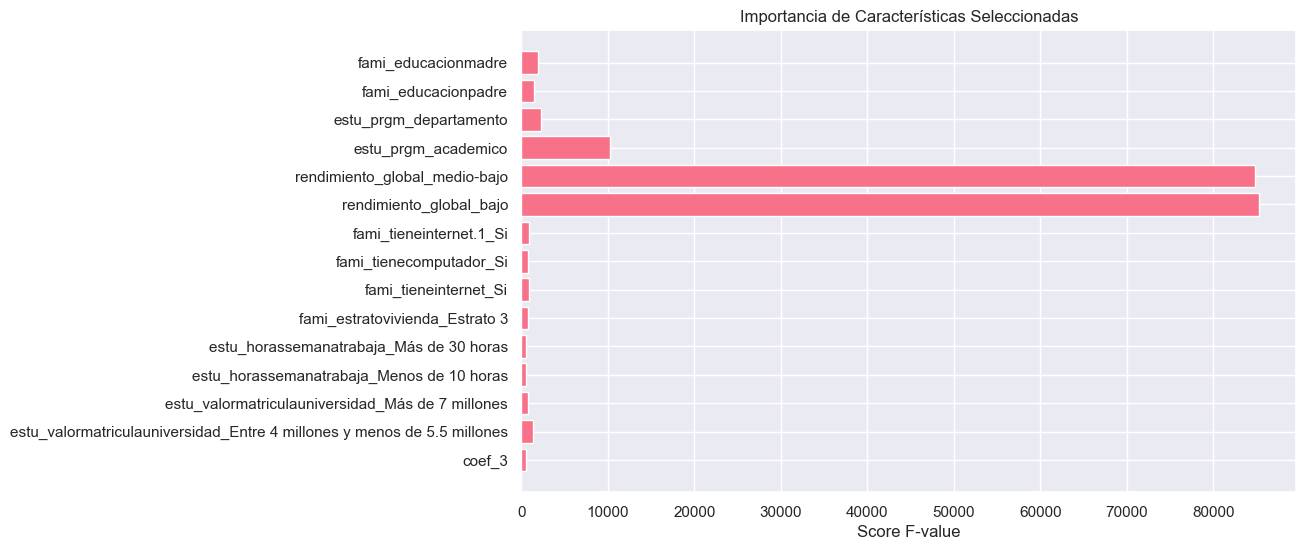


DataFrame con características seleccionadas:
     coef_3  \
0  0.813978   
1  0.508180   
2  0.729034   
3 -0.171371   
4  0.389259   

   estu_valormatriculauniversidad_Entre 4 millones y menos de 5.5 millones  \
0                                                0.0                         
1                                                0.0                         
2                                                0.0                         
3                                                1.0                         
4                                                0.0                         

   estu_valormatriculauniversidad_Más de 7 millones  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   estu_horassemanatrabaja_Menos de 10 horas  \
0              

In [43]:
# Analizar importancia de características
scores = selector.scores_[selector.get_support()]
plt.figure(figsize=(10, 6))
plt.barh(selected_features, scores)
plt.title('Importancia de Características Seleccionadas')
plt.xlabel('Score F-value')
plt.show()

# Crear nuevo DataFrame con características seleccionadas
df_selected = pd.DataFrame(X_selected, columns=selected_features)
df_selected[target] = y

print("\nDataFrame con características seleccionadas:")
print(df_selected.head())

# Ver distribución de la variable target
print("\nDistribución de la variable target:")
print(df_selected[target].value_counts(normalize=True))

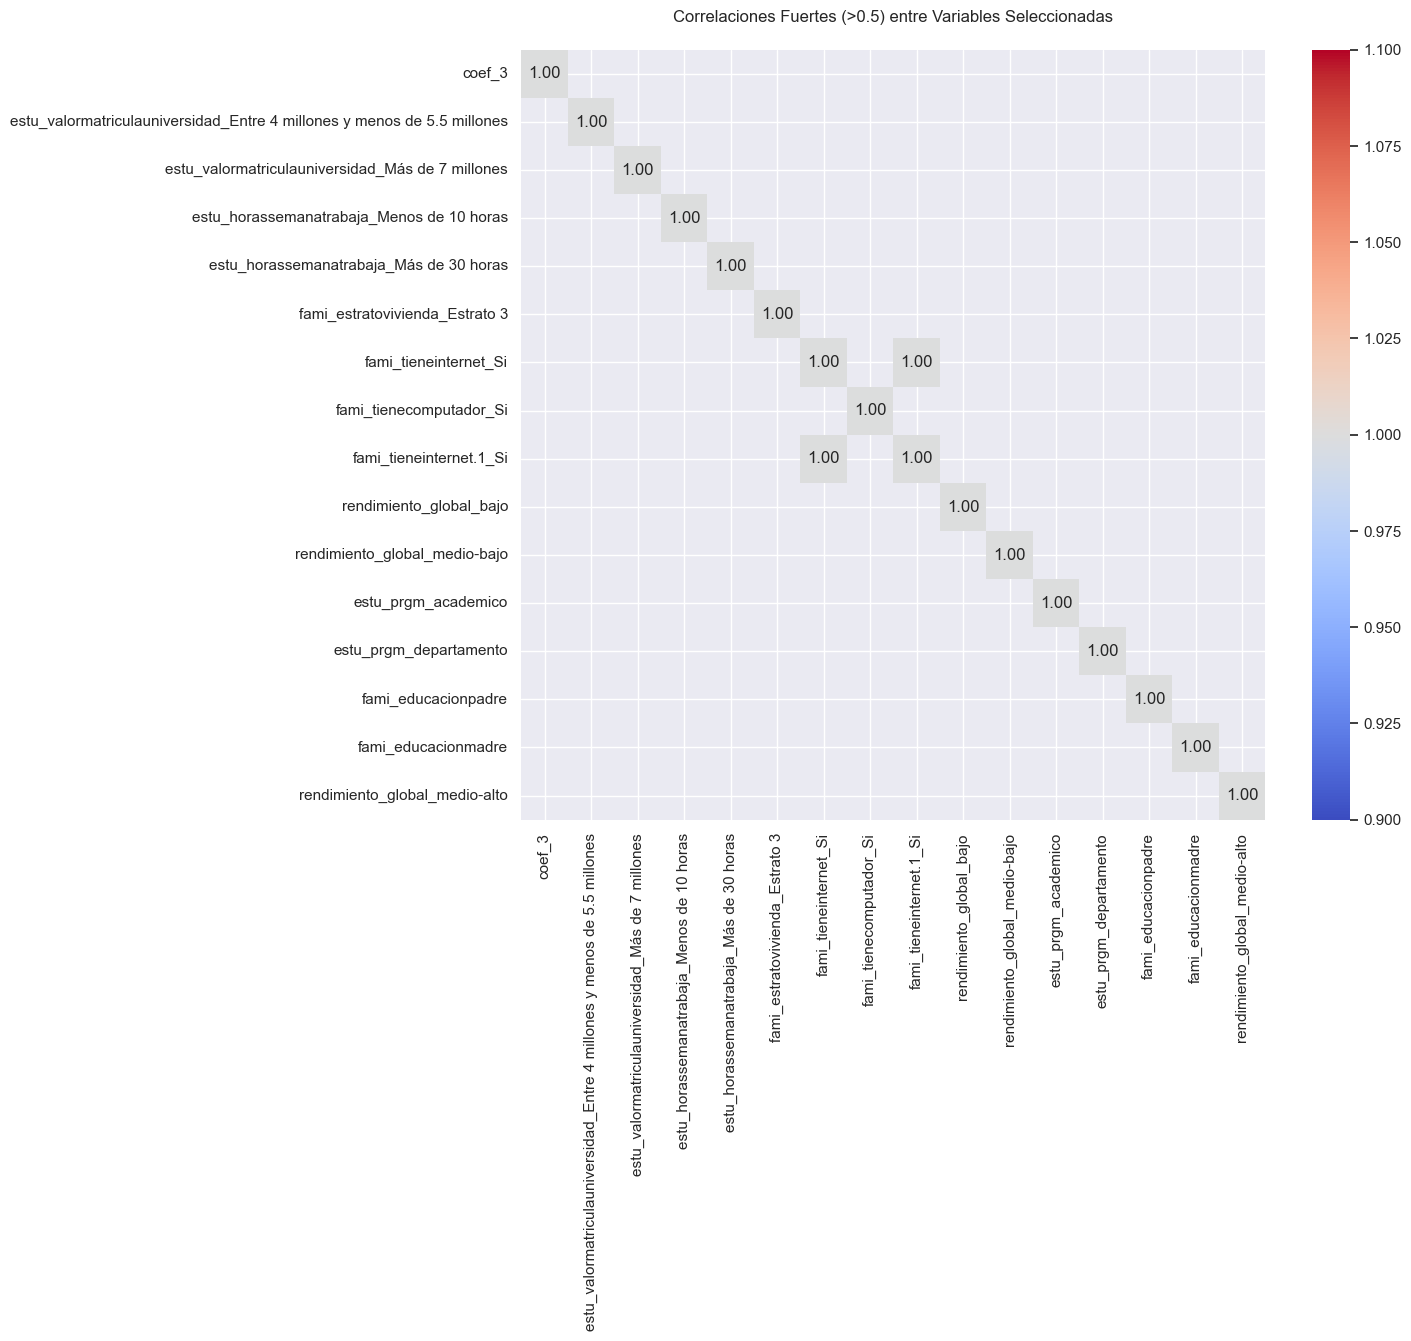

In [44]:
# Análisis de correlaciones
plt.figure(figsize=(12,10))
corr_matrix = df_selected.corr()
sns.heatmap(corr_matrix[abs(corr_matrix) > 0.5], cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlaciones Fuertes (>0.5) entre Variables Seleccionadas', pad=20)
plt.show()


In [45]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, random_state=42)

print("\nDistribución de conjuntos:")
print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Prueba: {X_test.shape[0]} muestras")



Distribución de conjuntos:
Entrenamiento: 554000 muestras
Prueba: 138500 muestras


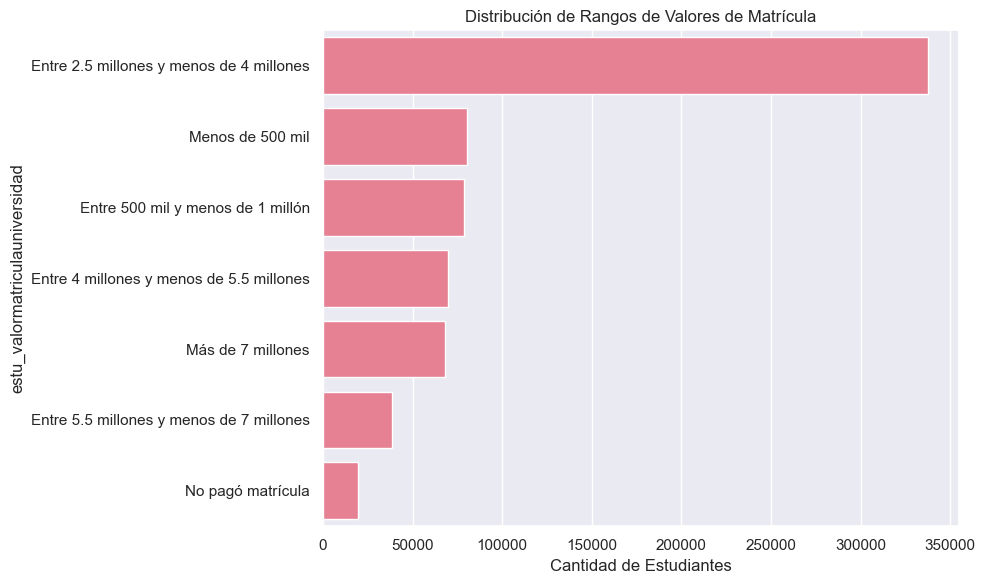

In [46]:
#visualizar graficos
# Definir columnas de rangos de matrícula
matricula_cols = [col for col in df.columns if col.startswith('estu_valormatriculauniversidad_')]

# Reconstruir la columna categórica original
df['estu_valormatriculauniversidad'] = df[matricula_cols].idxmax(axis=1).str.replace('estu_valormatriculauniversidad_', '')

# Contar ocurrencias por categoría
counts = df['estu_valormatriculauniversidad'].value_counts()

# Graficar
plt.figure(figsize=(10,6))
sns.countplot(data=df, y='estu_valormatriculauniversidad', order=counts.index)
plt.title('Distribución de Rangos de Valores de Matrícula')
plt.xlabel('Cantidad de Estudiantes')
plt.tight_layout()
plt.show()


In [ ]:
#Guardar el DataFrame procesado
df.to_csv("./data/train_preprocesado.csv", index=False)
print("Archivo preprocesado guardado correctamente.")


Archivo preprocesado guardado correctamente.
